In [1]:
#!pip3 install --user open3d
import cv2 as cv
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

In [3]:
import sys
import os
import glob

Import data, show sample images

In [4]:
sys.path.append('./samples')

In [5]:
root_path = './data/carla_sequence_00'

In [6]:
depth_dir = '/depth'
left_dir = '/left'
right_dir = '/right'
semantic_dir = '/semantic'

In [8]:
names = [os.path.basename(i) for i in sorted(glob.glob(root_path+left_dir+'/*'))]

In [9]:
def plot_show(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

(720, 1024, 3)


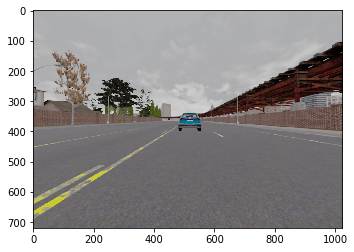

In [13]:
left = cv.imread(root_path+left_dir+'/'+names[0])
print(left.shape)
plot_show(left)

estimate initrics parameters and compute disparity

In [14]:
cx, cy = left.shape[1]/2, left.shape[0]/2

In [15]:
right = cv.imread(root_path+right_dir+'/'+names[0])

In [16]:
sgbm = cv.StereoSGBM_create(
    numDisparities=128,
    blockSize=3,
    P1=64, P2=1024,
    mode=cv.StereoSGBM_MODE_SGBM_3WAY)

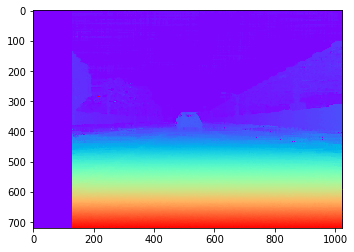

In [17]:
disp = sgbm.compute(left, right).astype(np.float32)/16.0
plt.imshow(disp, cmap='rainbow')

In [18]:
baseline = 0.21

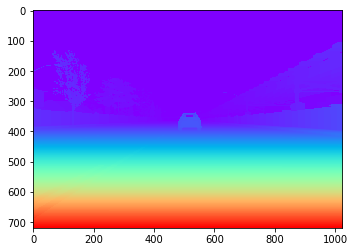

In [19]:
depth = cv.imread(root_path+depth_dir+'/'+names[0])

B, G, R = cv.split(depth.astype(np.float32))

normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
depth = 1000 * normalized
plt.imshow(1/normalized, cmap='rainbow')

In [20]:
F_map = depth[600:700, 400:600]*disp[600:700, 400:600]/baseline
print(F_map.min(), F_map.mean(), F_map.max())

505.0318882739818 511.1207401693167 515.3571340938404


In [21]:
F = 512

/home/sid1057/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/sid1057/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


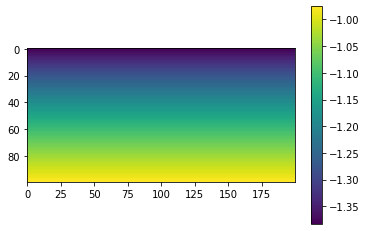

In [22]:
depth_est = B*F/disp

plt.imshow(depth_est[600:700, 400:600]-depth[600:700, 400:600])
plt.colorbar()


In [23]:
Q = np.asarray([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0,   F],
    [0, 0, -1/baseline,   0],
])

In [24]:
print(cx, cy, F, baseline)
print(Q)

512.0 360.0 512 0.21
[[   1.            0.            0.         -512.        ]
 [   0.            1.            0.         -360.        ]
 [   0.            0.            0.          512.        ]
 [   0.            0.           -4.76190476    0.        ]]


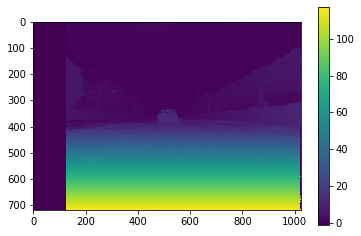

In [25]:
plt.imshow(disp)
plt.colorbar()

In [26]:
XYZ = cv.reprojectImageTo3D(disp, Q.astype(np.float32))

In [27]:
print(XYZ[..., 2].dtype)

float32


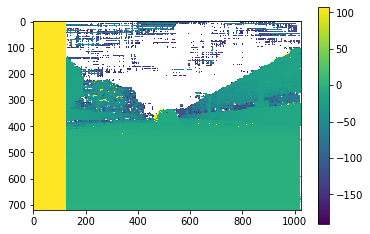

In [28]:
plt.imshow(XYZ[..., 2])
plt.colorbar()

/home/sid1057/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


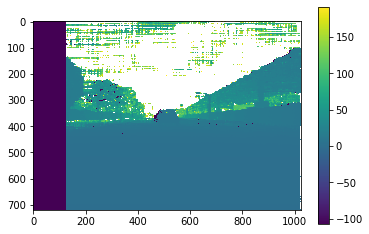

In [29]:
plt.imshow(baseline*F/disp)
plt.colorbar()

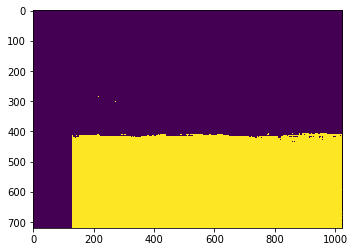

In [32]:
plt.imshow(cv.inRange(XYZ[..., 2]*-1, 0, 7.0))

try open3d image and depth representation

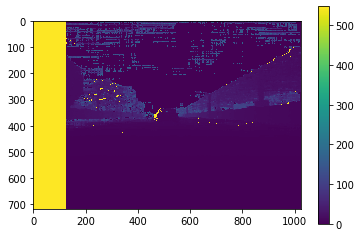

In [33]:
# color_raw = o3d.io.read_image('left.png')
# depth_raw = o3d.io.read_image('depth.png')

color_raw = o3d.geometry.Image(left)
depth_raw = o3d.geometry.Image((XYZ[..., 2]*-100).astype(np.int16))
# depth_raw = o3d.geometry.Image((baseline*F/disp*100).astype(np.int16))
# depth_raw = o3d.geometry.Image((depth/*100).astype(np.int16))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, depth_scale=100, depth_trunc=700, convert_rgb_to_intensity=False)

plt.imshow(rgbd_image.depth)
plt.colorbar()
plt.show()

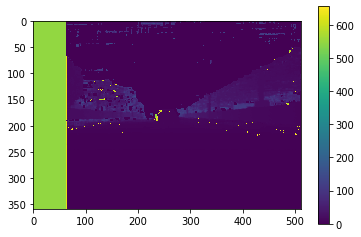

In [34]:
# color_raw = o3d.io.read_image('left.png')
# depth_raw = o3d.io.read_image('depth.png')

color_raw_down = o3d.geometry.Image(cv.pyrDown(left))
depth_raw_down = o3d.geometry.Image(cv.pyrDown(XYZ[..., 2]*-100).astype(np.int16))
# depth_raw = o3d.geometry.Image((baseline*F/disp*100).astype(np.int16))
# depth_raw = o3d.geometry.Image((depth/*100).astype(np.int16))
rgbd_image_down = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw_down, depth_raw_down, depth_scale=100, depth_trunc=700, convert_rgb_to_intensity=False)

plt.imshow(rgbd_image_down.depth)
plt.colorbar()
plt.show()

In [35]:
pinhole_parameters = o3d.camera.PinholeCameraIntrinsic(
        width=int(cx*2),
        height=int(cy*2),
        cx=cx, cy=cy,
        fx=F, fy=F,
)

pinhole_parameters_down = o3d.camera.PinholeCameraIntrinsic(
        width=int(cx),
        height=int(cy),
        cx=cx//2, cy=cy//2,
        fx=F//2, fy=F//2,
)


print(cx, cy)
print(F)

print(pinhole_parameters)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    pinhole_parameters,)

pcd_down = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image_down,
    pinhole_parameters_down,)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
pcd_down.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd, pcd_down])

512.0 360.0
512
camera::PinholeCameraIntrinsic with width = 1024 and height = 720.
Access intrinsics with intrinsic_matrix.


In [36]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    pinhole_parameters,)
print(pcd)
downpcd = pcd.voxel_down_sample(voxel_size=0.5,)
print(downpcd)
o3d.visualization.draw_geometries([downpcd])

geometry::PointCloud with 560547 points.
geometry::PointCloud with 151825 points.


In [37]:
import time

RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
None
RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
Delay: 0.12
True
[[ 0.99923975  0.00538565 -0.03861251  1.14037834]
 [-0.00503773  0.99994588  0.00910221  0.05095306]
 [ 0.03865944 -0.00890077  0.9992128  -0.19837195]
 [ 0.          0.          0.          1.        ]]
Velocity: 1.1586243576076292
[[233582.75853759 -19412.36366303  60932.0127896       0.
  -37687.36686146  -9265.76947941]
 [-19412.36366303 237053.12374412  70908.85205366  37687.36686146
       0.          10220.73266773]
 [ 60932.0127896   70908.85205366  57635.54601489   9265.76947941
  -10220.73266773      0.        ]
 [     0.          37687.3668

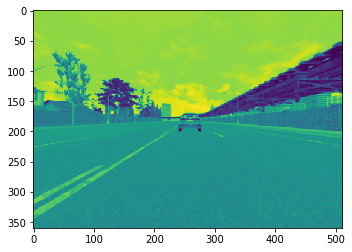

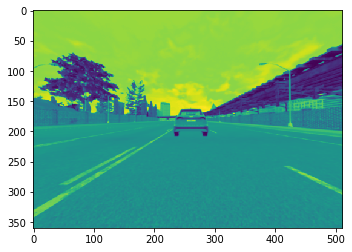

RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
Delay: 0.12
True
[[ 0.99898132 -0.01299147  0.04321507  0.10281802]
 [ 0.01313523  0.99990909 -0.00304435  0.11801611]
 [-0.04317159  0.00360889  0.99906115 -0.32684305]
 [ 0.          0.          0.          1.        ]]
Velocity: 0.3623889160682244
[[257296.79397179 -22559.00328885  91539.58225824      0.
  -72892.3956008  -15273.74838226]
 [-22559.00328885 286590.63706662  65137.59659548  72892.3956008
       0.          31728.23542672]
 [ 91539.58225824  65137.59659548  70395.50851154  15273.74838226
  -31728.23542672      0.        ]
 [     0.          72892.3956008   15273.74838226  33498.
       0.              0.        ]
 [-72892.3956008       0.         -31728.23542672      0.
   33498.              0

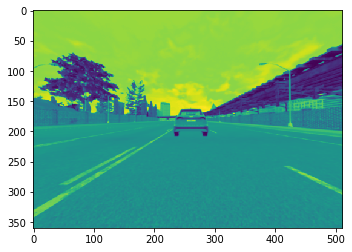

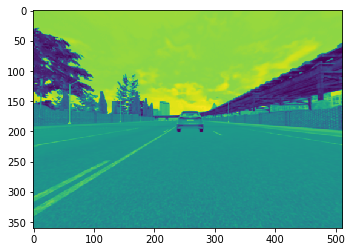

RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
RGBDImage of size 
Color image : 512x360, with 1 channels.
Depth image : 512x360, with 1 channels.
Use numpy.asarray to access buffer data.
Delay: 0.12
True
[[ 0.99775609 -0.05680696  0.03543649 -0.75342797]
 [ 0.05460871  0.99669214  0.06018855 -0.16121163]
 [-0.0387384  -0.05811835  0.99755781 -0.01442464]
 [ 0.          0.          0.          1.        ]]
Velocity: 0.770617266630972
[[56416.45317169 -4546.79282314 15814.10276443     0.
  -7874.96812415 -2272.94384623]
 [-4546.79282314 59294.72060736 16783.65635049  7874.96812415
      0.          3228.63653173]
 [15814.10276443 16783.65635049 14727.44638407  2272.94384623
  -3228.63653173     0.        ]
 [    0.          7874.96812415  2272.94384623  1773.
      0.             0.        ]
 [-7874.96812415     0.         -3228.63653173     0.
   1773.             0.        ]
 [-2272.94384623  3

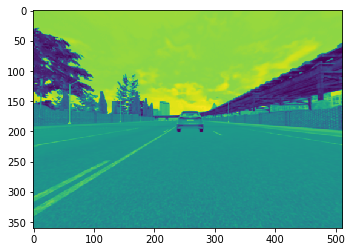

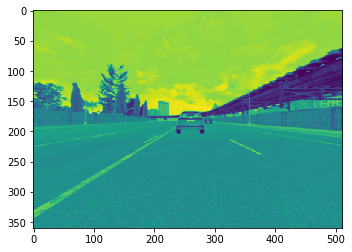

KeyboardInterrupt: 

In [38]:
pinhole_parameters = o3d.camera.PinholeCameraIntrinsic(
        width=int(cx*2),
        height=int(cy*2),
        cx=cx, cy=cy,
        fx=F, fy=F,
)
option = o3d.odometry.OdometryOption(
    min_depth=1, max_depth=30, max_depth_diff=0.1,
    iteration_number_per_pyramid_level = o3d.open3d.utility.IntVector([20, 10, 5, 3, 1])

)
odo_init = np.identity(4)
rgbd_old = None
pcd_old = None
pcd = None
trans_hybrid_term_old = np.identity(4)

coords = o3d.geometry.TriangleMesh.create_coordinate_frame( 10.0, np.asarray( [0.0, 0.0, 0.0] ) )
coords.compute_vertex_normals()

# vis = o3d.visualization.Visualizer()
# vis.create_window('odo')
# vis.add_geometry(pcd_old)
# vis.add_geometry(pcd)
trajectory = o3d.geometry.PointCloud()
trajectory += o3d.geometry.PointCloud(o3d.utility.Vector3dVector([[0, 0, 0]]))
pcd_story = []

for name in names[::5]:
    left = cv.imread(root_path+left_dir+'/'+name)
    right = cv.imread(root_path+right_dir+'/'+name)
    disp = sgbm.compute(left, right).astype(np.float32)/16.0
    XYZ = cv.reprojectImageTo3D(disp, Q.astype(np.float32))
    start = time.time()
    depth = (XYZ[..., 2]*-100).astype(np.int16)
    
#     depth = cv.imread(root_path+depth_dir+'/'+name)
#     B, G, R = cv.split(depth.astype(np.float32))
#     normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
#     depth = 1000 * normalized
#     depth = (depth*100).astype(np.int16)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(cv.pyrDown(left)),
        o3d.geometry.Image(cv.pyrDown(depth)),
        depth_scale=100, depth_trunc=60, convert_rgb_to_intensity=True)

    rgbd_new = rgbd_image
    print(rgbd_new)
    print(rgbd_old)
    
    if rgbd_old is None:
        rgbd_old = rgbd_image
        pcd_old = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image,
            pinhole_parameters,)
        continue
    [success_hybrid_term, trans_hybrid_term, info ] = o3d.odometry.compute_rgbd_odometry(
         rgbd_old, rgbd_new, pinhole_parameters,
         odo_init, o3d.odometry.RGBDOdometryJacobianFromHybridTerm(), option)
    stop = time.time()
    print('Delay: {:.2f}'.format(stop-start))
    print(success_hybrid_term)
    print(trans_hybrid_term)
    print('Velocity: {}'.format(sum([i**2 for i in trans_hybrid_term[:3,3]])**0.5))
    print(info)
    
    plt.imshow(rgbd_old.color)
    plt.show()
    plt.imshow(rgbd_new.color)
    plt.show()
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        pinhole_parameters,)
    
    
#     pcd_old.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    pcd_story.append(pcd_old)
    pcd_story = [i.transform(trans_hybrid_term) for i in pcd_story]
    trajectory.transform(trans_hybrid_term)
    coords.transform(trans_hybrid_term)
    trajectory += o3d.geometry.PointCloud(o3d.utility.Vector3dVector([[0, 0, 0]]))
#     pcd_old.transform(trans_hybrid_term)
    
    o3d.visualization.draw_geometries([*pcd_story, trajectory, coords], )
#     o3d.visualization.draw_geometries([pcd, pcd_old])
    
    rgbd_old = rgbd_image
    pcd_old = pcd
#     vis.update_geometry(pcd)
#     vis.poll_events()
#     vis.update_renderer()
#     if save_image:
#         vis.capture_screen_image("temp_%04d.jpg" % i)
# vis.destroy_window()